In [147]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [148]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam

# Preparazione dei dati
Il dataset viene caricato, diviso in features (variabili predittive) e target (variabile da predire: probabilità di default di pagamento).  
L'ID del cliente e la variabile target stessa vengono escluse dalle features.
Le features numeriche vengono identificate e sottoposte a normalizzazione tramite StandardScaler. Questo processo centra i dati sottraendo la media e li scala dividendo per la deviazione standard.
Con questi passaggi, i dati sono pronti per l'addestramento e la valutazione del modello.

In [149]:
# Caricamento del dataset dal file CSV
dataset = pd.read_csv("drive/MyDrive/MachineLearning/datasets/creditdataset.csv")

# Separazione delle caratteristiche (features) e dei target
featuresDataFrame = dataset.drop(columns=['default payment next month','ID'])
targetsDataFrame = dataset['default payment next month']

variabili_numeriche = list(featuresDataFrame.columns[:])
print(variabili_numeriche)

#normaliziamo
scaler = StandardScaler()
scaled_data = scaler.fit_transform(featuresDataFrame[variabili_numeriche])

['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


In [190]:
dataset.corr()

ID  LIMIT_BAL       SEX  EDUCATION  \
ID                          1.000000   0.026179  0.018497   0.039177   
LIMIT_BAL                   0.026179   1.000000  0.024755  -0.219161   
SEX                         0.018497   0.024755  1.000000   0.014232   
EDUCATION                   0.039177  -0.219161  0.014232   1.000000   
MARRIAGE                   -0.029079  -0.108139 -0.031389  -0.143464   
AGE                         0.018678   0.144713 -0.090874   0.175061   
PAY_0                      -0.030575  -0.271214 -0.057643   0.105364   
PAY_2                      -0.011215  -0.296382 -0.070771   0.121566   
PAY_3                      -0.018494  -0.286123 -0.066096   0.114025   
PAY_4                      -0.002735  -0.267460 -0.060173   0.108793   
PAY_5                      -0.022199  -0.249411 -0.055064   0.097520   
PAY_6                      -0.020270  -0.235195 -0.044008   0.082316   
BILL_AMT1                   0.019389   0.285430 -0.033642   0.023581   
BILL_AMT2                   0.017982   0.278314 -0.031183   0.018749   
BILL_AMT3                   0.024354   0.283236 -0.024563   0.013002   
BILL_AMT4                   0.040351   0.293988 -0.021880  -0.000451   
BILL_AMT5                   0.016705   0.295562 -0.017005  -0.007567   
BILL_AMT6                   0.016730   0.290389 -0.016733  -0.009099   
PAY_AMT1                    0.009742   0.195236 -0.000242  -0.037456   
PAY_AMT2                    0.008406   0.178408 -0.001391  -0.030038   
PAY_AMT3                    0.039151   0.210167 -0.008597  -0.039943   
PAY_AMT4                    0.007793   0.203242 -0.002229  -0.038218   
PAY_AMT5                    0.000652   0.217202 -0.001667  -0.040358   
PAY_AMT6                    0.003000   0.219595 -0.002766  -0.037200   
default payment next month -0.013952  -0.153520 -0.039961   0.028006   

                            MARRIAGE       AGE     PAY_0     PAY_2     PAY_3  \
ID                         -0.029079  0.018678 -0.030575 -0.011215 -0.018494   
LIMIT_BAL                  -0.108139  0.144713 -0.271214 -0.296382 -0.286123   
SEX                        -0.031389 -0.090874 -0.057643 -0.070771 -0.066096   
EDUCATION                  -0.143464  0.175061  0.105364  0.121566  0.114025   
MARRIAGE                    1.000000 -0.414170  0.019917  0.024199  0.032688   
AGE                        -0.414170  1.000000 -0.039447 -0.050148 -0.053048   
PAY_0                       0.019917 -0.039447  1.000000  0.672164  0.574245   
PAY_2                       0.024199 -0.050148  0.672164  1.000000  0.766552   
PAY_3                       0.032688 -0.053048  0.574245  0.766552  1.000000   
PAY_4                       0.033122 -0.049722  0.538841  0.662067  0.777359   
PAY_5                       0.035629 -0.053826  0.509426  0.622780  0.686775   
PAY_6                       0.034345 -0.048773  0.474553  0.575501  0.632684   
BILL_AMT1                  -0.023472  0.056239  0.187068  0.234887  0.208473   
BILL_AMT2                  -0.021602  0.054283  0.189859  0.235257  0.237295   
BILL_AMT3                  -0.024909  0.053710  0.179785  0.224146  0.227494   
BILL_AMT4                  -0.023344  0.051353  0.179125  0.222237  0.227202   
BILL_AMT5                  -0.025393  0.049345  0.180635  0.221348  0.225145   
BILL_AMT6                  -0.021207  0.047613  0.176980  0.219403  0.222327   
PAY_AMT1                   -0.005979  0.026147 -0.079269 -0.080701  0.001295   
PAY_AMT2                   -0.008093  0.021785 -0.070101 -0.058990 -0.066793   
PAY_AMT3                   -0.003541  0.029247 -0.070561 -0.055901 -0.053311   
PAY_AMT4                   -0.012659  0.021379 -0.064005 -0.046858 -0.046067   
PAY_AMT5                   -0.001205  0.022850 -0.058190 -0.037093 -0.035863   
PAY_AMT6                   -0.006641  0.019478 -0.058673 -0.036500 -0.035861   
default payment next month -0.024339  0.013890  0.324794  0.263551  0.235253   

                               PAY_4  ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  \
ID

# Riduzione della Dimensionalità con PCA
Per ridurre la complessità del dataset e migliorare l'efficienza del modello, viene applicata la Principal Component Analysis (PCA). La PCA è una tecnica statistica che permette di identificare le combinazioni lineari delle features originali (componenti principali) che catturano la maggior parte della varianza presente nei dati.
Inizialmente, la PCA viene eseguita senza specificare il numero di componenti da mantenere, per analizzare la varianza spiegata da ciascuna componente e determinare quante di esse sono sufficienti per rappresentare adeguatamente i dati.
Successivamente, la PCA viene applicata nuovamente, specificando il numero di componenti principali desiderato (in questo caso 15 ottenendo una somma delle varianze spiegate superiore al 95%). I dati originali vengono quindi trasformati proiettandoli nello spazio definito da queste 15 componenti principali, ottenendo un nuovo dataset con dimensionalità ridotta.
Questo processo di riduzione della dimensionalità permette di semplificare il dataset, eliminando le features meno informative e mantenendo quelle che contribuiscono maggiormente alla varianza dei dati. Ciò può portare a un miglioramento delle performance del modello, riducendo il rischio di overfitting e velocizzando l'addestramento.

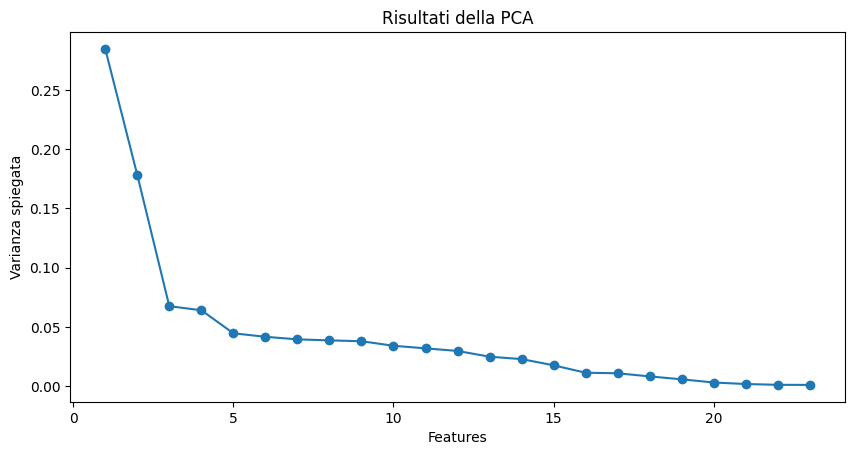

[0.284 0.178 0.067 0.064 0.045 0.042 0.039 0.039 0.038 0.034 0.032 0.03
 0.025 0.023 0.018]
Somma delle varianze spiegate: 0.96


In [151]:
#calcoliamo la varianza spiegata per ogni componente
pca = PCA().fit(scaled_data)

# Crea un grafico della varianza spiegata per ogni componente
plt.figure().set_figwidth(10)
plt.plot(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_, marker='o')
plt.xlabel('Features')
plt.ylabel('Varianza spiegata')
plt.title("Risultati della PCA")
plt.show()

# Applica la PCA per ridurre la dimensionalità dei dati
pca = PCA(n_components=15).fit(scaled_data)
pca_data = pca.transform(scaled_data)

# Quantifichiamo  la percentuale di varianza spiegata da ciascuno delle componenti derivate.
rounded_ratios = np.around(pca.explained_variance_ratio_, decimals=3)
print(rounded_ratios)
# E la somma delle varianze spiegate
print("Somma delle varianze spiegate: %.2f" % np.sum(pca.explained_variance_ratio_))

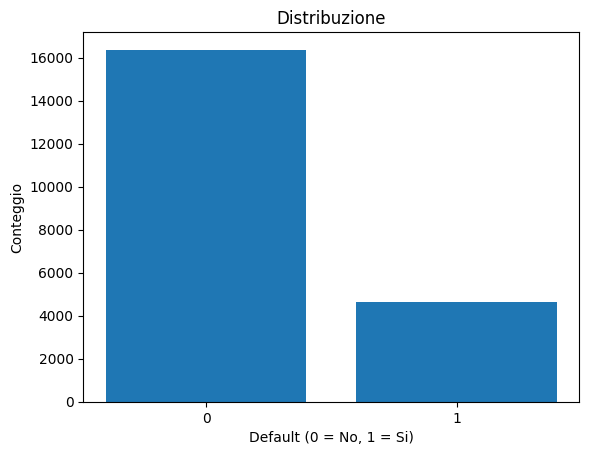

In [152]:
# Suddivisione in istanze di Training e di Test
Xtrain, Xtest, Ytrain, Ytest = train_test_split(pca_data, targetsDataFrame, test_size=0.3, random_state=1)

# Crea un grafico a barre per visualizzare la distribuzione della variabile target
plt.bar(Ytrain.unique(), Ytrain.value_counts())
plt.xlabel('Default (0 = No, 1 = Si)')
plt.xticks([0, 1])
plt.ylabel('Conteggio')
plt.title('Distribuzione')
plt.show()

In [153]:
# il nostro alberò avrà massima profondità 5 e utilizzerà l'entropia per effettuare gli split
prunedModel = DecisionTreeClassifier(max_depth=5, random_state=42,criterion='entropy')

# addestriamo il modello
prunedModel = prunedModel.fit(Xtrain, Ytrain)

# Visualizza l'albero decisionale
fig, ax = plt.subplots(figsize=(150, 100))
plot_tree(prunedModel, filled=True, ax=ax)
plt.plot()

Output hidden; open in https://colab.research.google.com to view.

In [154]:
# predizione del nuovo modello
Ypred = prunedModel.predict(Xtest)

cm = confusion_matrix(Ytest, Ypred)

print("Confusion matrix of the pruned model:\n", cm)
print("\nAccuracy of the pruned model:", cm.diagonal().sum() / cm.sum())

Confusion matrix of the pruned model:
 [[6668  332]
 [1381  619]]

Accuracy of the pruned model: 0.8096666666666666


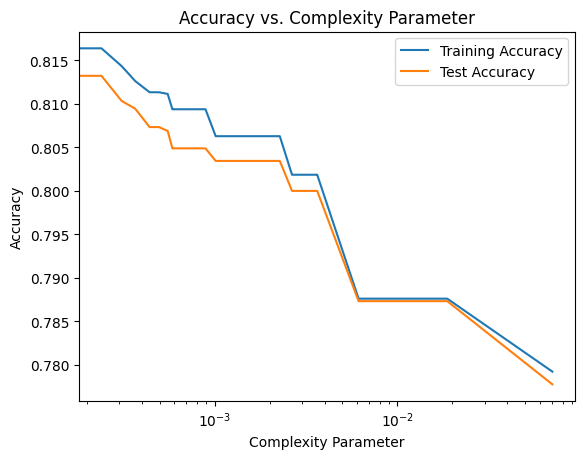

In [155]:
path = prunedModel.cost_complexity_pruning_path(Xtrain, Ytrain)
ccp_alphas = path.ccp_alphas


# Addestra l'albero decisionale con diversi valori di complessità
train_accuracy = []
test_accuracy = []
for complexity in ccp_alphas:
    clf = DecisionTreeClassifier(max_depth=5, ccp_alpha=complexity)
    clf.fit(Xtrain, Ytrain)
    train_accuracy.append(clf.score(Xtrain, Ytrain))
    test_accuracy.append(clf.score(Xtest, Ytest))

# Plotta l'accuratezza del modello in funzione del parametro di complessità
plt.plot(ccp_alphas, train_accuracy, label='Training Accuracy')
plt.plot(ccp_alphas, test_accuracy, label='Test Accuracy')
plt.xlabel('Complexity Parameter')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Complexity Parameter')
plt.xscale('log')
plt.legend()
plt.show()

In [156]:
# il nostro alberò avrà massima profondità 5 e utilizzerà l'entropia per effettuare gli split
prunedModel = DecisionTreeClassifier( random_state=42,ccp_alpha=1 / 10**2.3,criterion='entropy')
prunedModel = prunedModel.fit(Xtrain, Ytrain)

# Visualizza l'albero decisionale
fig, ax = plt.subplots(figsize=(150, 100))
plot_tree(prunedModel, filled=True, ax=ax)
plt.plot()

[]

In [157]:
# predizione del nuovo modello
Ypred1 = prunedModel.predict(Xtest)

cm = confusion_matrix(Ytest, Ypred1)

print("Confusion matrix of the pruned model:\n", cm)
print("\nAccuracy of the pruned model:", cm.diagonal().sum() / cm.sum())

Confusion matrix of the pruned model:
 [[6752  248]
 [1552  448]]

Accuracy of the pruned model: 0.8


In [158]:
accuracy_train_test = accuracy_score(Ytest, Ypred1)
precision = precision_score(Ytest, Ypred1, pos_label=0)
recall = recall_score(Ytest, Ypred1,pos_label=0)
f1 = f1_score(Ytest, Ypred1, pos_label=0)

# Stampa le prestazioni del modello
print('Accuracy:', accuracy_train_test)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1)
print("\n", classification_report(Ypred1, Ytest))

Accuracy: 0.8
Precision: 0.8131021194605009
Recall: 0.9645714285714285
F1-score: 0.8823836905384214

               precision    recall  f1-score   support

           0       0.96      0.81      0.88      8304
           1       0.22      0.64      0.33       696

    accuracy                           0.80      9000
   macro avg       0.59      0.73      0.61      9000
weighted avg       0.91      0.80      0.84      9000



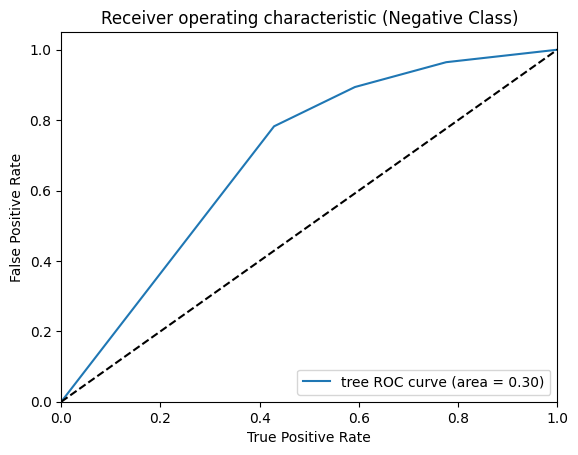

In [159]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Probabilità per la classe negativa
tree_y_pred_prob_neg = prunedModel.predict_proba(Xtest)[:, 0]

# Calcola la curva ROC per i negativi
treeFpr, treeTpr, treeThresholds = roc_curve(Ytest, tree_y_pred_prob_neg, pos_label=0)

# Calcola l'AUC della curva ROC
tree_roc_auc = roc_auc_score(Ytest, tree_y_pred_prob_neg)

# Disegna la curva ROC
plt.plot(treeFpr, treeTpr, label='tree ROC curve (area = %0.2f)' % tree_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('Receiver operating characteristic (Negative Class)')
plt.legend(loc="lower right")
plt.show()


rete multi

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


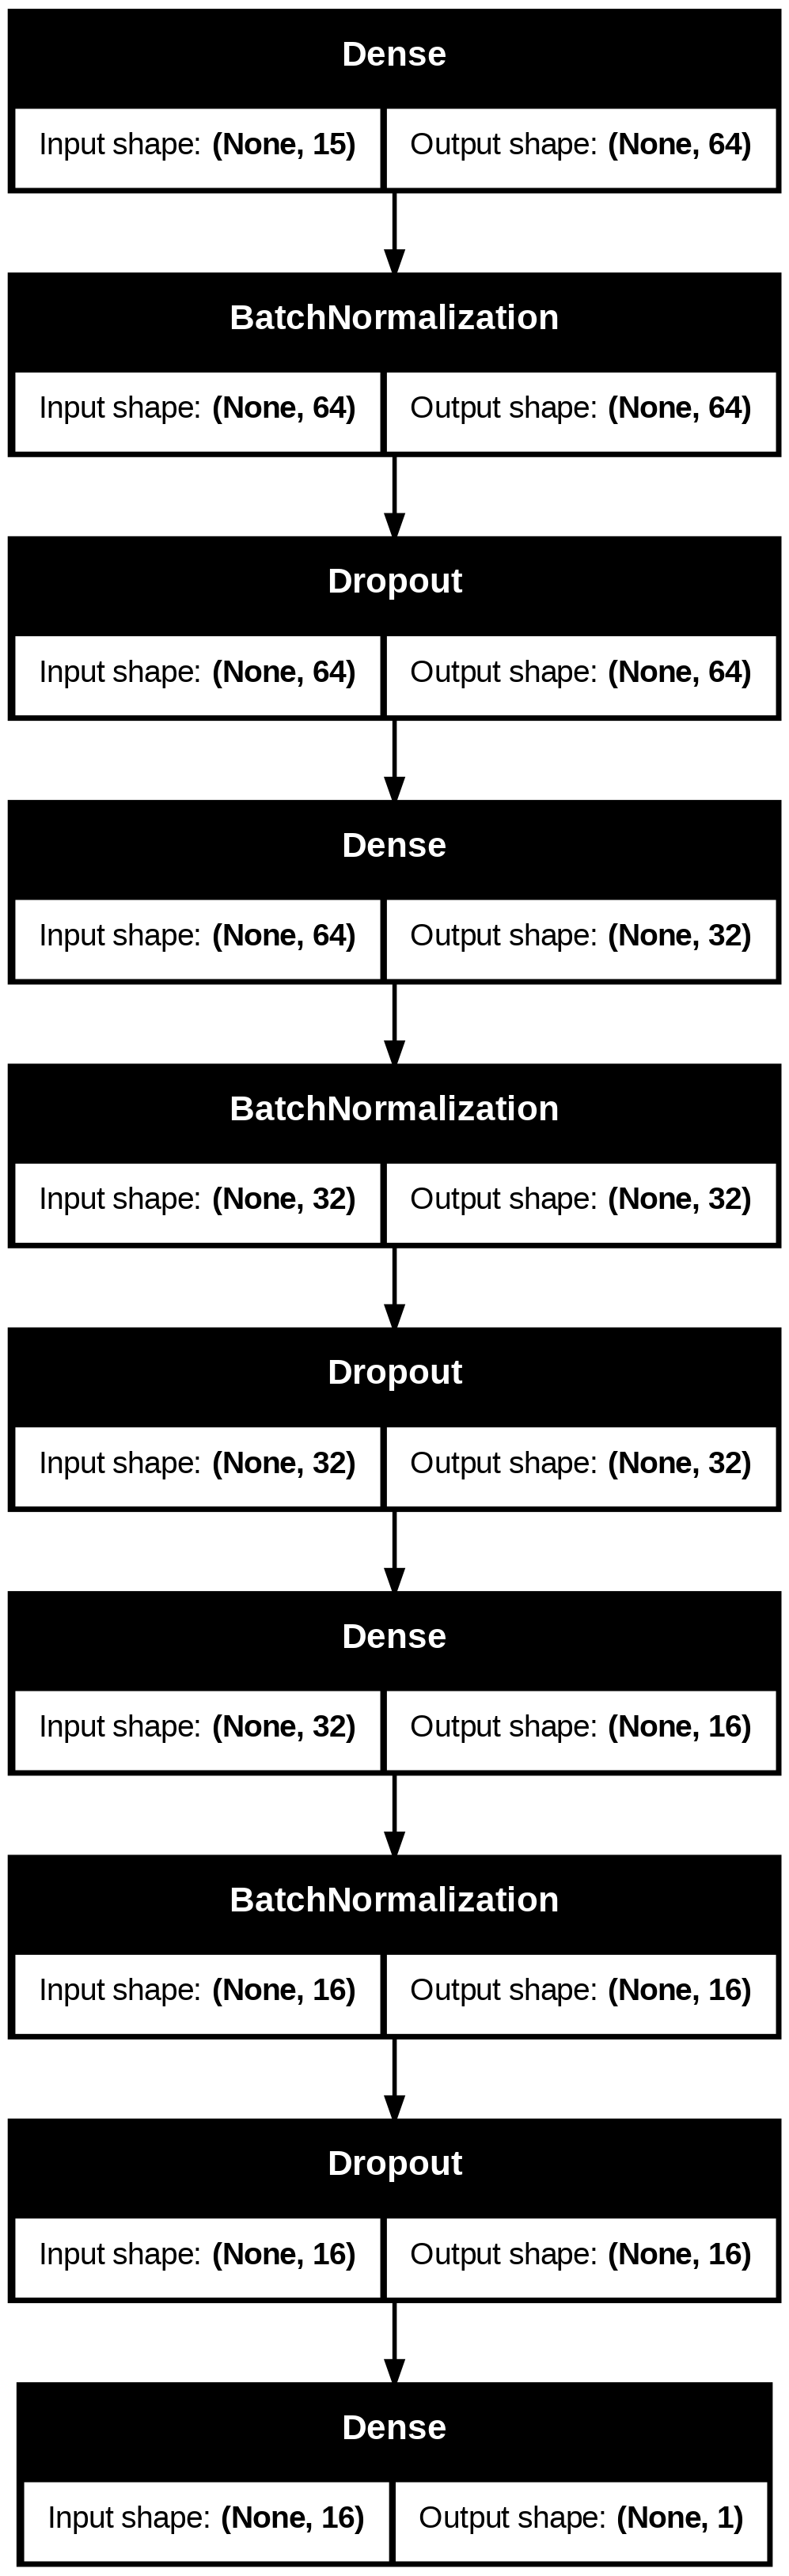

In [160]:

# Creazione del modello
model = Sequential()

# Primo layer nascosto con 64 neuroni, attivazione ReLU, BatchNormalization e Dropout per ridurre overfitting
model.add(Dense(64, input_shape=(15,), activation='relu'))
model.add(BatchNormalization())  # Normalizzazione per stabilizzare l'allenamento
model.add(Dropout(0.3))  # Dropout per evitare overfitting

# Secondo layer nascosto con 32 neuroni e attivazione ReLU
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Terzo layer nascosto con 16 neuroni e attivazione ReLU
model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Layer di output con un neurone e funzione di attivazione sigmoid (per classificazione binaria)
model.add(Dense(1, activation='sigmoid'))

# Compilazione del modello con l'ottimizzatore Adam e funzione di perdita binaria crossentropy
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])

# Visualizzazione del modello
keras.utils.plot_model(model, show_shapes=True)


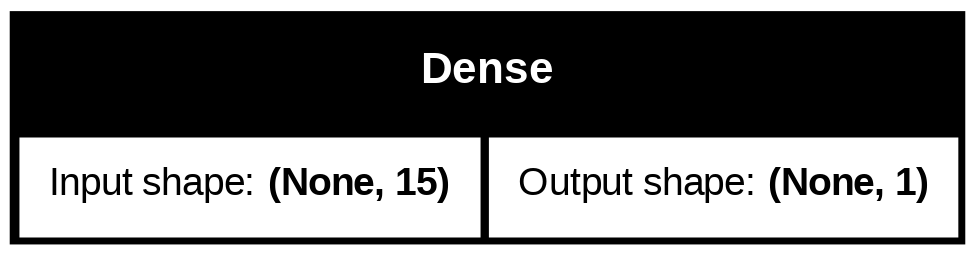

In [161]:
simpleModel = Sequential()
# Add an initial layer with 4 input nodes, and a hidden layer with 16 nodes.
# Apply the sigmoid activation function to that layer.
simpleModel.add(Dense(1, input_shape=(15,), activation='sigmoid'))
# Add another layer, connected to the layer with 16 nodes, containing three output nodes.
# Use the softmax activation function there.
#model.add(Dense(1, activation='softmax'))


# Compile the model
simpleModel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

keras.utils.plot_model(simpleModel, show_shapes=True)

In [162]:
model.summary()
simpleModel.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_34 (Dense)                     │ (None, 64)                  │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 16)                  │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,097 (16.00 KB)

 Trainable params: 3,873 (15.13 KB)

 Non-trainable params: 224 (896.00 B)

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_38 (Dense)                     │ (None, 1)                   │              16 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16 (64.00 B)

 Trainable params: 16 (64.00 B)

 Non-trainable params: 0 (0.00 B)

In [163]:
# Train the model
history = model.fit(Xtrain, Ytrain, epochs=5, batch_size=5, verbose=1)

# Evaluate the model on the test set
score = model.evaluate(Xtest, Ytest, verbose=0)
#print('Test loss:', score[0])
#print('Test accuracy:', score[1])

Epoch 1/5
4200/4200 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.6767 - loss: 0.6265
Epoch 2/5
4200/4200 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.7855 - loss: 0.4938
Epoch 3/5
4200/4200 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.7897 - loss: 0.4832
Epoch 4/5
4200/4200 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.7924 - loss: 0.4825
Epoch 5/5
4200/4200 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.7985 - loss: 0.4707


In [164]:
# Train the model
history = simpleModel.fit(Xtrain, Ytrain, epochs=5, batch_size=5, verbose=1)

# Evaluate the model on the test set
score = simpleModel.evaluate(Xtest, Ytest, verbose=0)
#print('Test loss:', score[0])
#print('Test accuracy:', score[1])

Epoch 1/5
4200/4200 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.6937 - loss: 0.6151
Epoch 2/5
4200/4200 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.8171 - loss: 0.4597
Epoch 3/5
4200/4200 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.8085 - loss: 0.4680
Epoch 4/5
4200/4200 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8118 - loss: 0.4656
Epoch 5/5
4200/4200 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8085 - loss: 0.4705


In [165]:
YpredProb1 = model.predict(Xtest)
Ypred11 = (YpredProb1 >= 0.5).astype(int)

accuracy_train_test = accuracy_score(Ytest, Ypred11)
precision = precision_score(Ytest, Ypred11, pos_label=0)
recall = recall_score(Ytest, Ypred11, pos_label=0)
f1 = f1_score(Ytest, Ypred11, pos_label=0)

# Stampa le prestazioni del modello
print('Accuracy:', accuracy_train_test)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1)

282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy: 0.8115555555555556
Precision: 0.8233357717629847
Recall: 0.9647142857142857
F1-score: 0.8884357321405079


In [166]:
simpleYpredProb1 = simpleModel.predict(Xtest)
Ypred111 = (simpleYpredProb1 >= 0.5).astype(int)

accuracy_train_test = accuracy_score(Ytest, Ypred111)
precision = precision_score(Ytest, Ypred111, pos_label=0)
recall = recall_score(Ytest, Ypred111, pos_label=0)
f1 = f1_score(Ytest, Ypred111, pos_label=0)

# Stampa le prestazioni del modello
print('Accuracy:', accuracy_train_test)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1)

282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy: 0.8055555555555556
Precision: 0.8124256129492978
Recall: 0.9751428571428571
F1-score: 0.8863783924165692


In [167]:
from sklearn.metrics import classification_report

print(classification_report(Ypred11, Ytest))

              precision    recall  f1-score   support

           0       0.96      0.82      0.89      8202
           1       0.28      0.69      0.39       798

    accuracy                           0.81      9000
   macro avg       0.62      0.76      0.64      9000
weighted avg       0.90      0.81      0.84      9000



In [168]:
from sklearn.metrics import classification_report

print(classification_report(Ypred111, Ytest))

              precision    recall  f1-score   support

           0       0.98      0.81      0.89      8402
           1       0.21      0.71      0.33       598

    accuracy                           0.81      9000
   macro avg       0.59      0.76      0.61      9000
weighted avg       0.92      0.81      0.85      9000



282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


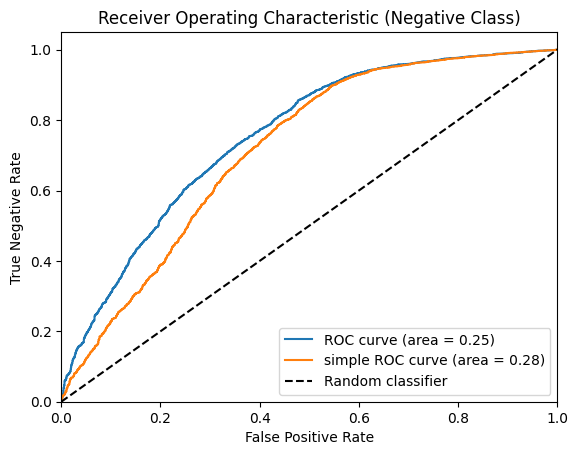

In [169]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Predizioni probabilistiche del modello
YpredProb1 = model.predict(Xtest)
simpleYpredProb1 = simpleModel.predict(Xtest)
#perchè vogliamo lavorare sui negativi
YpredProbNegativa = 1 - YpredProb1
simpleYpredProbNegativa = 1 - simpleYpredProb1

# Calcola la curva ROC per la classe negativa (pos_label=0)
fpr, tpr, thresholds = roc_curve(Ytest, YpredProbNegativa, pos_label=0)
simpleFpr, simpleTpr, simpleThresholds = roc_curve(Ytest, simpleYpredProbNegativa, pos_label=0)
# Calcola l'AUC della curva ROC per la classe negativa
roc_auc = roc_auc_score(Ytest, YpredProbNegativa)
simple_roc_auc = roc_auc_score(Ytest, simpleYpredProbNegativa)

# Disegna la curva ROC per la classe negativa

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot(simpleFpr, simpleTpr, label='simple ROC curve (area = %0.2f)' % simple_roc_auc)

plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')  # Linea diagonale
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Negative Rate')  # Tasso di veri negativi
plt.title('Receiver Operating Characteristic (Negative Class)')
plt.legend(loc="lower right")
plt.show()


282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


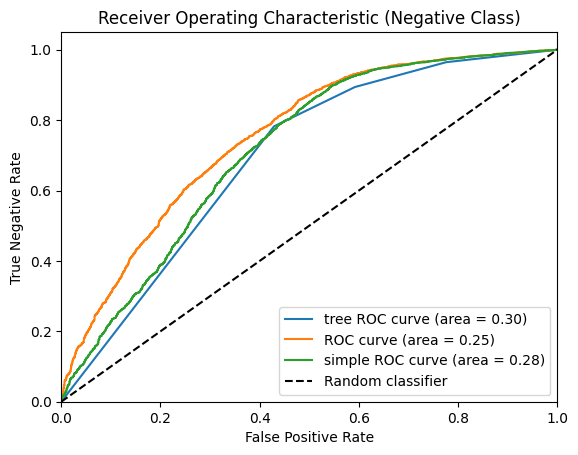

In [170]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Predizioni probabilistiche del modello
YpredProb1 = model.predict(Xtest)
simpleYpredProb1 = simpleModel.predict(Xtest)
#perchè vogliamo lavorare sui negativi
YpredProbNegativa = 1 - YpredProb1
simpleYpredProbNegativa = 1 - simpleYpredProb1

# Calcola la curva ROC per la classe negativa (pos_label=0)
fpr, tpr, thresholds = roc_curve(Ytest, YpredProbNegativa, pos_label=0)
simpleFpr, simpleTpr, simpleThresholds = roc_curve(Ytest, simpleYpredProbNegativa, pos_label=0)
# Calcola l'AUC della curva ROC per la classe negativa
roc_auc = roc_auc_score(Ytest, YpredProbNegativa)
simple_roc_auc = roc_auc_score(Ytest, simpleYpredProbNegativa)

# Disegna la curva ROC per la classe negativa
plt.plot(treeFpr, treeTpr, label='tree ROC curve (area = %0.2f)' % tree_roc_auc)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot(simpleFpr, simpleTpr, label='simple ROC curve (area = %0.2f)' % simple_roc_auc)

plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')  # Linea diagonale
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Negative Rate')  # Tasso di veri negativi
plt.title('Receiver Operating Characteristic (Negative Class)')
plt.legend(loc="lower right")
plt.show()


dict_keys(['accuracy', 'loss'])


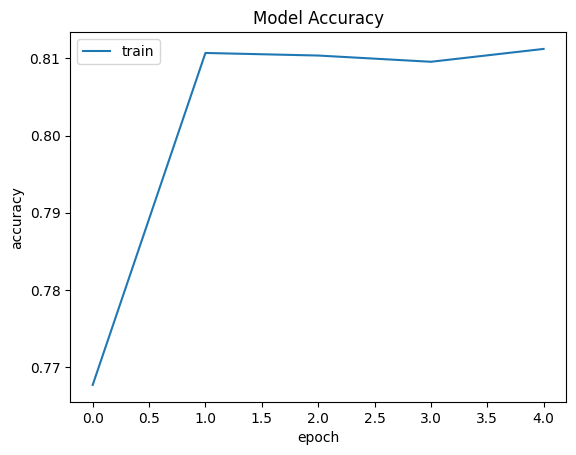

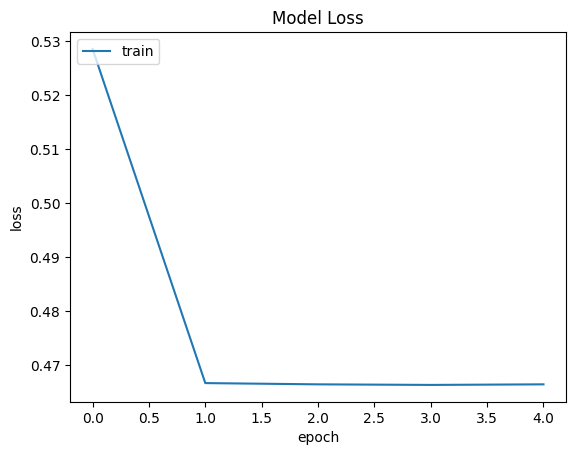

In [171]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

senza applicare PCA

ci sono già poche features, non si guadagna nulla a fare una riduzione di dimensionalità

In [172]:
# Suddivisione in istanze di Training e di Test
Xtrain1, Xtest1, Ytrain1, Ytest1 = train_test_split(featuresDataFrame, targetsDataFrame, test_size=0.3, random_state=1)

In [173]:
# il nostro albero avrà massima profondià 8 e utilzzerà l'entropia per effettuare gli split
prunedModel = DecisionTreeClassifier(max_depth=8, random_state=42,ccp_alpha=1 / 10**3.5,criterion='entropy')

# addestriamo il modello
prunedModel = prunedModel.fit(Xtrain1, Ytrain1)

# Visualizza l'albero decisionale
fig, ax = plt.subplots(figsize=(150, 100))
plot_tree(prunedModel, filled=True, ax=ax)
plt.plot()

Output hidden; open in https://colab.research.google.com to view.

In [174]:
# predizione del nuovo modello
Ypred12 = prunedModel.predict(Xtest1)

cm = confusion_matrix(Ytest1, Ypred12)

print("Confusion matrix of the pruned model:\n", cm)
print("\nAccuracy of the pruned model:", cm.diagonal().sum() / cm.sum())

Confusion matrix of the pruned model:
 [[6588  412]
 [1238  762]]

Accuracy of the pruned model: 0.8166666666666667


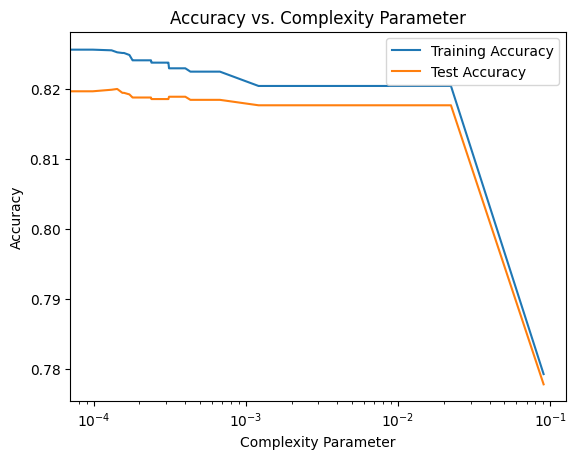

In [175]:
path = prunedModel.cost_complexity_pruning_path(Xtrain1, Ytrain1)
ccp_alphas = path.ccp_alphas


# Addestra l'albero decisionale con diversi valori di complessità
train_accuracy = []
test_accuracy = []
for complexity in ccp_alphas:
    clf = DecisionTreeClassifier(max_depth=5, ccp_alpha=complexity)
    clf.fit(Xtrain1, Ytrain1)
    train_accuracy.append(clf.score(Xtrain1, Ytrain1))
    test_accuracy.append(clf.score(Xtest1, Ytest1))

# Plotta l'accuratezza del modello in funzione del parametro di complessità
plt.plot(ccp_alphas, train_accuracy, label='Training Accuracy')
plt.plot(ccp_alphas, test_accuracy, label='Test Accuracy')
plt.xlabel('Complexity Parameter')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Complexity Parameter')
plt.xscale('log')
plt.legend()
plt.show()

In [176]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn.tree import DecisionTreeClassifier, plot_tree


prunedModel = DecisionTreeClassifier( random_state=42,ccp_alpha=1 / 10**1.6,criterion='entropy')
prunedModel = prunedModel.fit(Xtrain1, Ytrain1)

# Visualizza l'albero decisionale
fig, ax = plt.subplots(figsize=(150, 100))
plot_tree(prunedModel, filled=True, ax=ax)
plt.plot()

[]

In [177]:
from sklearn.metrics import confusion_matrix

# predizione del nuovo modello
Ypred = prunedModel.predict(Xtest1)

cm = confusion_matrix(Ytest1, Ypred1)

print("Confusion matrix of the pruned model:\n", cm)
print("\nAccuracy of the pruned model:", cm.diagonal().sum() / cm.sum())

Confusion matrix of the pruned model:
 [[6752  248]
 [1552  448]]

Accuracy of the pruned model: 0.8


In [178]:
# Valuta il modello utilizzando i dati di test
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy_train_test = accuracy_score(Ytest1, Ypred1)
precision = precision_score(Ytest1, Ypred1, pos_label=0)
recall = recall_score(Ytest1, Ypred1, pos_label=0)
f1 = f1_score(Ytest1, Ypred1, pos_label=0)

# Stampa le prestazioni del modello
print('Accuracy:', accuracy_train_test)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1)

Accuracy: 0.8
Precision: 0.8131021194605009
Recall: 0.9645714285714285
F1-score: 0.8823836905384214


In [179]:
from sklearn.metrics import classification_report

print(classification_report(Ypred12, Ytest1))

              precision    recall  f1-score   support

           0       0.94      0.84      0.89      7826
           1       0.38      0.65      0.48      1174

    accuracy                           0.82      9000
   macro avg       0.66      0.75      0.68      9000
weighted avg       0.87      0.82      0.84      9000



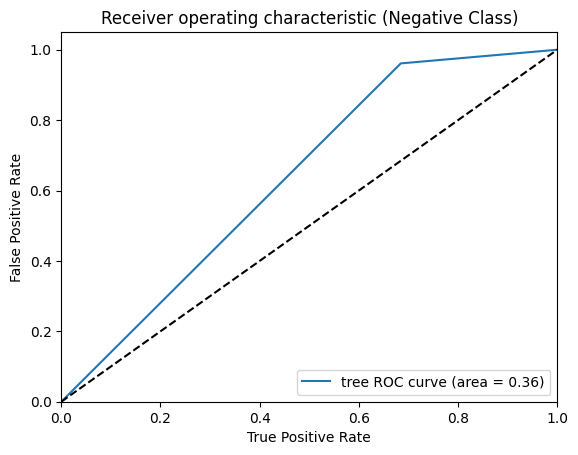

In [180]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Probabilità per la classe negativa
nonPCAtreeY_pred_prob_neg1 = prunedModel.predict_proba(Xtest1)[:, 0]

# Calcola la curva ROC per i negativi
nonPCAtreeFpr, nonPCATreeTpr, nonPCATreethresholds = roc_curve(Ytest1, nonPCAtreeY_pred_prob_neg1, pos_label=0)

# Calcola l'AUC della curva ROC
nonPCAtree_roc_auc = roc_auc_score(Ytest1, nonPCAtreeY_pred_prob_neg1)

# Disegna la curva ROC
plt.plot(nonPCAtreeFpr, nonPCATreeTpr, label='tree ROC curve (area = %0.2f)' % nonPCAtree_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('Receiver operating characteristic (Negative Class)')
plt.legend(loc="lower right")
plt.show()


MultiSingolStrato senza PCA

lavora meglio

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


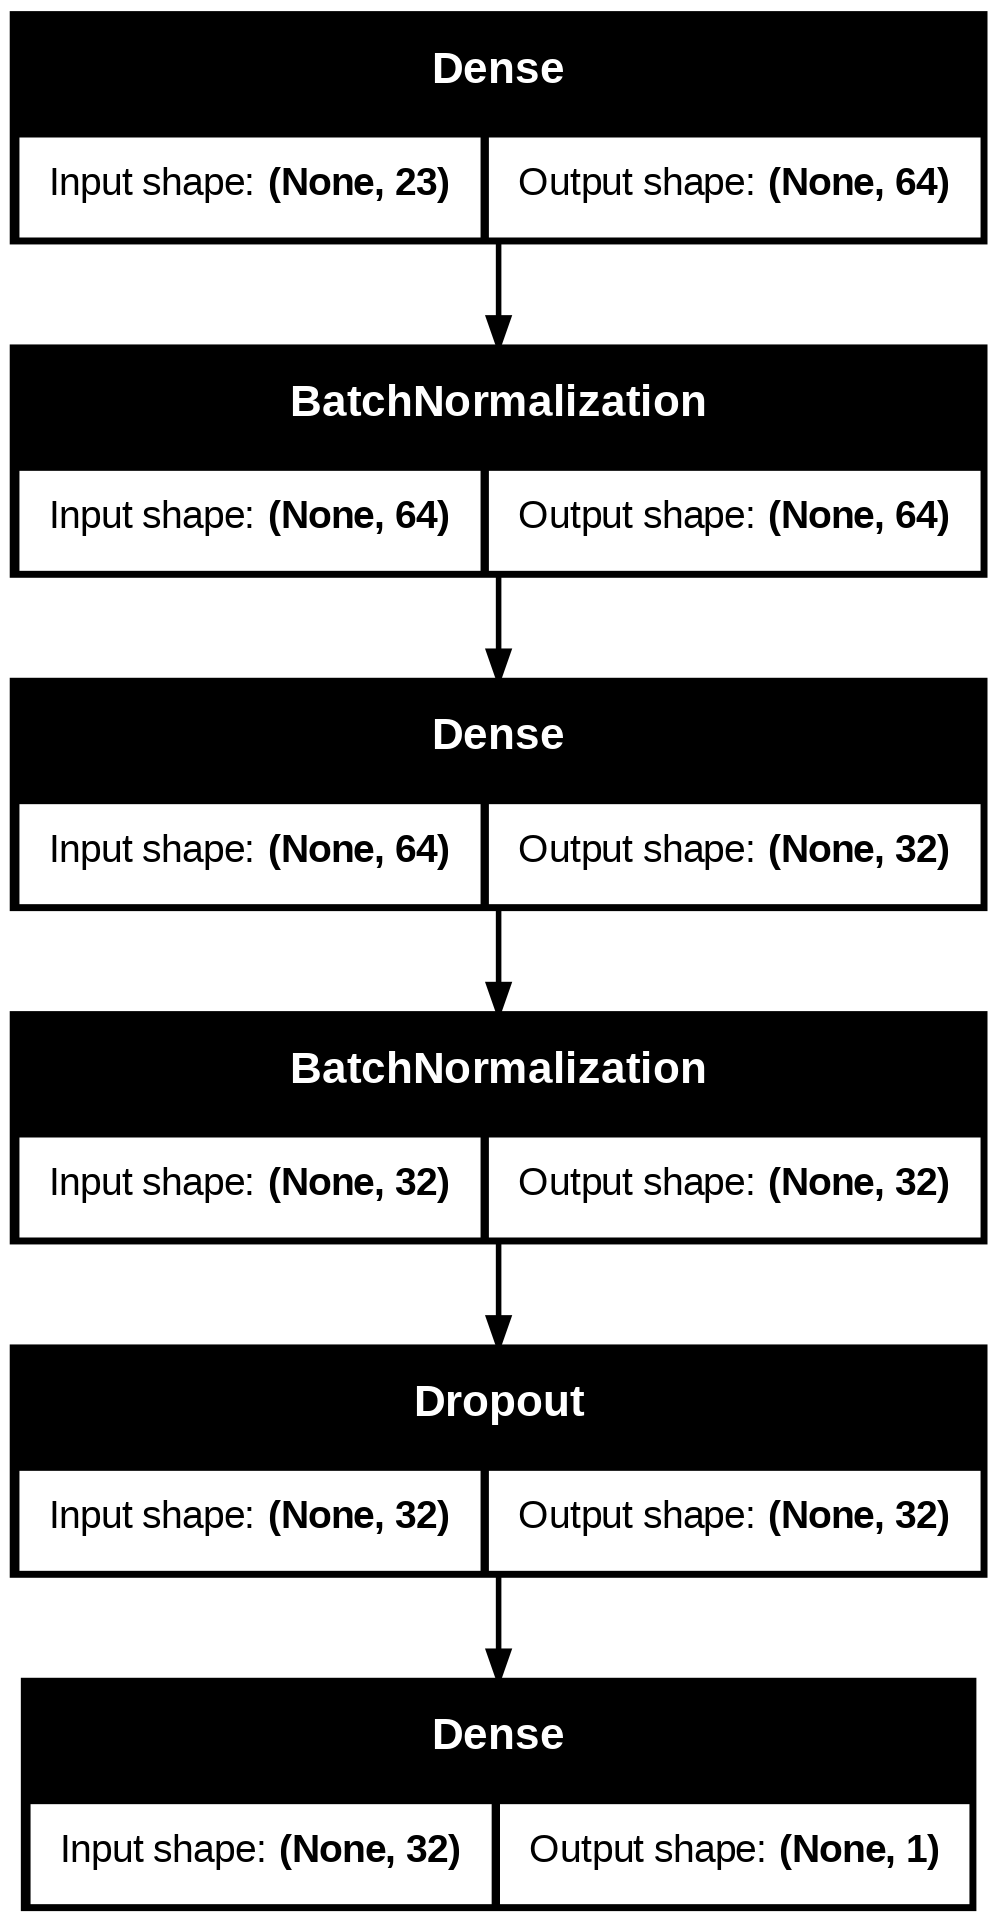

In [181]:
from keras.regularizers import l2

# Crea il modello
model = Sequential()

# Primo layer nascosto con L2 regularization
model.add(Dense(64, input_shape=(23,), activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())

# Secondo layer nascosto con L2 regularization
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())

# Aggiunta di Dropout
model.add(Dropout(0.3))

# Layer di output con 1 neurone e funzione di attivazione sigmoid
model.add(Dense(1, activation='sigmoid'))

# Compilazione del modello
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Visualizzazione del modello
keras.utils.plot_model(model, show_shapes=True)

In [182]:
model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_39 (Dense)                     │ (None, 64)                  │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,033 (15.75 KB)

 Trainable params: 3,841 (15.00 KB)

 Non-trainable params: 192 (768.00 B)

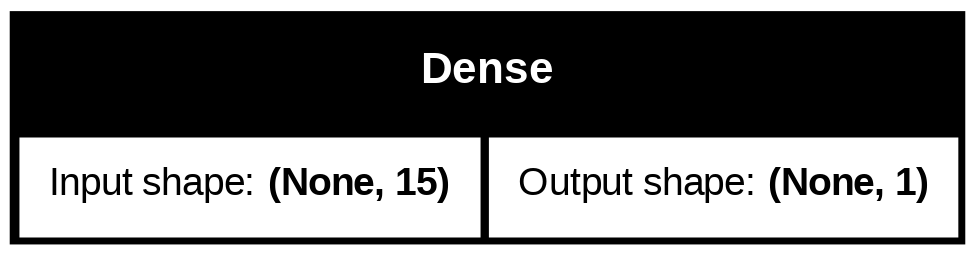

In [183]:
nonPCAsimpleModel = Sequential()
# Add an initial layer with 4 input nodes, and a hidden layer with 16 nodes.
# Apply the sigmoid activation function to that layer.
nonPCAsimpleModel.add(Dense(1, input_shape=(23,), activation='sigmoid'))
# Add another layer, connected to the layer with 16 nodes, containing three output nodes.
# Use the softmax activation function there.
#model.add(Dense(1, activation='softmax'))


# Compile the model
nonPCAsimpleModel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

keras.utils.plot_model(simpleModel, show_shapes=True)

In [184]:
nonPCAsimpleModel.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_42 (Dense)                     │ (None, 1)                   │              24 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24 (96.00 B)

 Trainable params: 24 (96.00 B)

 Non-trainable params: 0 (0.00 B)

In [185]:
# Train the model
history = model.fit(Xtrain1, Ytrain1, epochs=5, batch_size=5, verbose=1)

# Evaluate the model on the test set
score = model.evaluate(Xtest1, Ytest1, verbose=0)
#print('Test loss:', score[0])
#print('Test accuracy:', score[1])

Epoch 1/5
4200/4200 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.7195 - loss: 0.8558
Epoch 2/5
4200/4200 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7857 - loss: 0.5290
Epoch 3/5
4200/4200 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.7785 - loss: 0.5272
Epoch 4/5
4200/4200 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.7752 - loss: 0.5259
Epoch 5/5
4200/4200 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7805 - loss: 0.5212


se non si usa PCA un servono degli hidden layer o le pereformance sono inferiori

In [186]:
# Train the model
history = nonPCAsimpleModel.fit(Xtrain1, Ytrain1, epochs=5, batch_size=5, verbose=1)

# Evaluate the model on the test set
score = nonPCAsimpleModel.evaluate(Xtest1, Ytest1, verbose=0)
#print('Test loss:', score[0])
#print('Test accuracy:', score[1])

Epoch 1/5
4200/4200 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.5365 - loss: 14113.5244
Epoch 2/5
4200/4200 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.6899 - loss: 129.7308
Epoch 3/5
4200/4200 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.7069 - loss: 79.9710
Epoch 4/5
4200/4200 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.6932 - loss: 72.7285
Epoch 5/5
4200/4200 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.6914 - loss: 75.5406


In [187]:
YpredProb = model.predict(Xtest1)
Ypred13 = (YpredProb >= 0.5).astype(int)

accuracy_train_test = accuracy_score(Ytest1, Ypred13)
precision = precision_score(Ytest1, Ypred13, pos_label=0)
recall = recall_score(Ytest1, Ypred13, pos_label=0)
f1 = f1_score(Ytest1, Ypred13, pos_label=0)

# Stampa le prestazioni del modello
print('Accuracy:', accuracy_train_test)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1)

282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy: 0.7776666666666666
Precision: 0.7778148271646105
Recall: 0.9997142857142857
F1-score: 0.874914046383697


In [188]:
nonPCAsimpleYpredProb = nonPCAsimpleModel.predict(Xtest1)
nonPCAsimpleYpred13 = (nonPCAsimpleYpredProb >= 0.5).astype(int)

accuracy_train_test = accuracy_score(Ytest1, Ypred13)
precision = precision_score(Ytest1, nonPCAsimpleYpred13, pos_label=0)
recall = recall_score(Ytest1, nonPCAsimpleYpred13, pos_label=0)
f1 = f1_score(Ytest1, nonPCAsimpleYpred13, pos_label=0)

# Stampa le prestazioni del modello
print('Accuracy:', accuracy_train_test)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1)

282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy: 0.7776666666666666
Precision: 0.7805450078177351
Recall: 0.9984285714285714
F1-score: 0.8761439137520372


282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


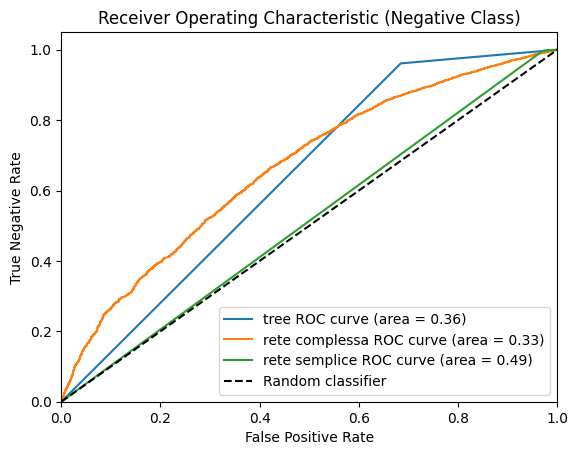

In [189]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Predizioni probabilistiche del modello
YpredProb11 = model.predict(Xtest1)
nonPCAYpredProb11 = nonPCAsimpleModel.predict(Xtest1)
#perchè vogliamo lavorare sui negativi
YpredProbNegativa1 = 1 - YpredProb11
nonPCAYpredProbNegativa1 = 1 - nonPCAYpredProb11

# Calcola la curva ROC per la classe negativa (pos_label=0)
fpr, tpr, thresholds = roc_curve(Ytest1, YpredProbNegativa1, pos_label=0)
nonPCAFpr, nonPCATpr, nonPCAThresholds = roc_curve(Ytest1, nonPCAYpredProbNegativa1, pos_label=0)

# Calcola l'AUC della curva ROC per la classe negativa
roc_auc = roc_auc_score(Ytest1, YpredProbNegativa1)
nonPCA_roc_auc = roc_auc_score(Ytest1, nonPCAYpredProbNegativa1)

# Disegna la curva ROC per la classe negativa
plt.plot(nonPCAtreeFpr, nonPCATreeTpr, label='tree ROC curve (area = %0.2f)' % nonPCAtree_roc_auc)
plt.plot(fpr, tpr, label='rete complessa ROC curve (area = %0.2f)' % roc_auc)
plt.plot(nonPCAFpr, nonPCATpr, label='rete semplice ROC curve (area = %0.2f)' % nonPCA_roc_auc)

plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')  # Linea diagonale
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Negative Rate')  # Tasso di veri negativi
plt.title('Receiver Operating Characteristic (Negative Class)')
plt.legend(loc="lower right")
plt.show()
